In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
import torch, pickle, numpy


# setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
nfft = 2**18
pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
ramp_slope = (f_end-f_start) / t_chirp
hertz_per_meter = ramp_slope / lightspeed
bins_per_meter = nfft / maxdist
do_unwrap = True

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
dists = [2.143, 8.099, 18.016, 32.284]
angle_offsets = [-3*pi/180,-2*pi/180,0*pi/180,0*pi/180]
exc = 0

angles = [pickle.load(open(folder+f'a{int(dist):02d}_angle.pkl', 'rb')) for dist in dists]
degs = [list(map(lambda a : round(a*180/pi - 90), angle)) for angle in angles]
l_degs = [[deg.index(a) for a in sorted(set(deg)) if -60<a<60] for deg in degs]
angles_filtered = [[angle[l]+offs for l in l_deg] for angle,l_deg,offs in zip(angles,l_degs,angle_offsets)]
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']
vx, vy = params['vxPosX'], params['vxPosY']
ula = [[x if y==0 else -1000 for x,y in zip(vx,vy)].index(x) for x in sorted(set(vx))]

cpu


In [ ]:
K=192
from math import sin,cos

a = torch.tensor([list(map(sin,angles_filtered[0])), [0]*len(angles_filtered[0]), list(map(sin,angles_filtered[0]))]).unsqueeze(1)
b = torch.tensor([tx, ty, [-exc]*K]).unsqueeze(-1)
print(a.shape)
print(b.shape)
print((b-a).shape)
print((b-a).square().sum(0).sqrt().shape)

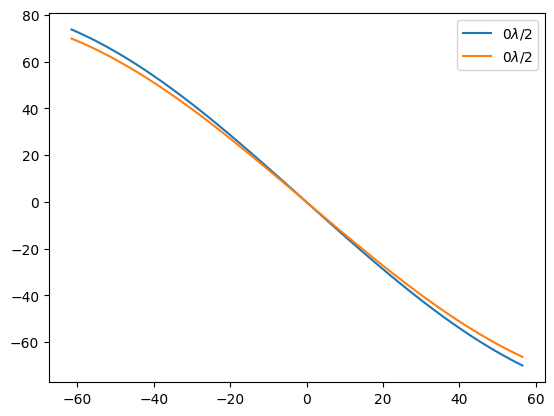

In [26]:
from math import sin,cos
phase_ests = []
for dist, angle, l_deg in zip(dists[:1], angles_filtered, l_degs):
    # reflpos: [3,L] -> [3,1,L]
    L=len(angle)
    K=len(tx)
    reflpos = (dist-exc)*torch.tensor([\
                list(map(lambda a: -sin(a-pi/2),angle)),\
                [-exc]*L,\
                list(map(lambda a: cos(a-pi/2),angle))\
                ]\
            ).unsqueeze(1)
    # txpos, rxpos: [3,K] -> [3,K,1]
    txpos = torch.tensor([tx, ty, [-exc]*K]).unsqueeze(-1)
    rxpos = torch.tensor([rx, ry, [-exc]*K]).unsqueeze(-1)
    # estimate: [3,K,L] -> [K,L]
    dist_est = (reflpos-txpos).square().sum(0).sqrt()/2 + (reflpos-rxpos).square().sum(0).sqrt()/2
    phase_est = 2*pi*f_start * (2*dist_est/lightspeed)
    phase_ests.append(phase_est)
    plt.plot([180/pi*a-90 for a in angle], (phase_est[ula[0],:]-phase_est[ula[-1],:])/pi, label=r'$0\lambda/2$')

for dist, angle, l_deg in zip(dists[:1], angles_filtered, l_degs):
    # reflpos: [3,L] -> [3,1,L]
    L=len(angle)
    K=len(tx)
    reflpos = (dist-exc)*torch.tensor([\
                list(map(lambda a: -sin(a-pi/2),angle)),\
                [-exc]*L,\
                list(map(lambda a: cos(a-pi/2),angle))\
                ]\
            ).unsqueeze(1)
    # txpos, rxpos: [3,K] -> [3,K,1]
    txpos = torch.tensor([tx, ty, [-exc]*K]).unsqueeze(-1)
    rxpos = torch.tensor([rx, ry, [-exc]*K]).unsqueeze(-1)
    # estimate: [3,K,L] -> [K,L]
    dist_est = (reflpos-txpos).square().sum(0).sqrt()/2 + (reflpos-rxpos).square().sum(0).sqrt()/2
    phase_est = 2*pi*(f_start-4e9) * (2*dist_est/lightspeed)
    phase_ests.append(phase_est)
    plt.plot([180/pi*a-90 for a in angle], (phase_est[ula[0],:]-phase_est[ula[-1],:])/pi, label=r'$0\lambda/2$')

plt.legend()
plt.show()

In [3]:
imgs = []
for dist, angle, l_deg, phase_est in zip(dists, angles_filtered, l_degs, phase_ests):
    print(f'Loading {folder}a{int(dist):02d}_bp_fft.pt...', end='')
    fft = torch.load(f'{folder}a{int(dist):02d}_bp_fft.pt')[:,:,l_deg]
    M,K,L = fft.shape
    print('Done')
    m_refl = ((lightspeed*phase_est/(4*pi*f_start)-int(dist)+0.5)*bins_per_meter).clamp(0,bins_per_meter-1).int()
    
    img = [[fft[m_refl[k,l],k,l].angle() for l in range(L)] for k in range(K)]
    imgs.append(img)


NameError: name 'phase_ests' is not defined

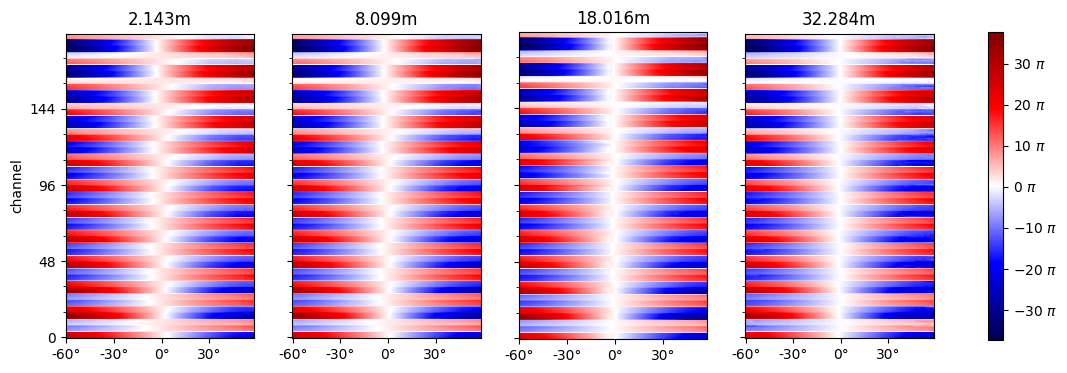

In [83]:
fig, axes = plt.subplots(1,4, sharey=True)
for ax, dist, img, angle in zip(axes.flat, dists, imgs, angles_filtered):
    img = numpy.unwrap(img, axis=-1)
    img -= img[:,59, None]
    im = ax.imshow(img/pi, origin='lower', cmap='seismic')
    ax.set_title(f'{dist}m')
    ax.yaxis.set_ticks(range(0,192,16*3), minor=False)
    ax.yaxis.set_ticks(range(0,192,16), minor=True)
    ax.set_xticks(range(0, len(angle),30),\
                [f'{a}°' for a in range(int(round(angle[0]*180/pi-90,-1)),int(round(angle[-1]*180/pi-90,-1)),30)])
axes[0].set_ylabel('channel')
fig.colorbar(im, ax=list(axes.flat), shrink=0.5, format=EngFormatter(r'$\pi$'))
fig.set_size_inches(14,8)

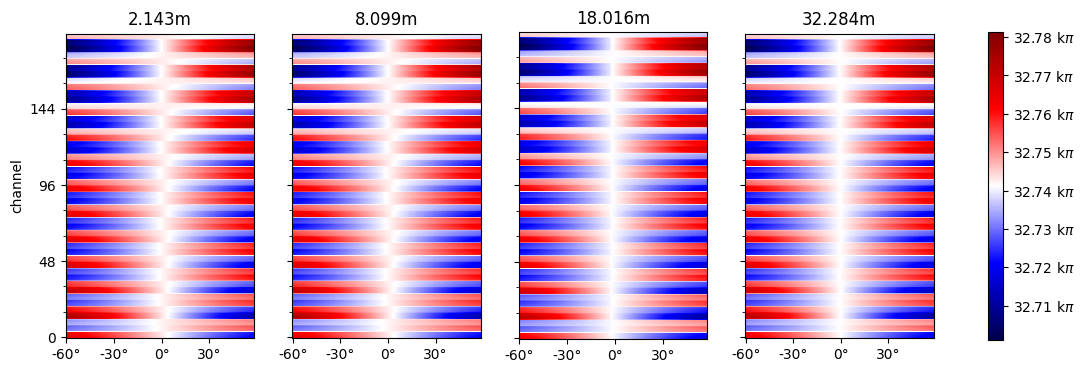

In [86]:
fig, axes = plt.subplots(1,4, sharey=True)
for ax, dist, phase_est, angle in zip(axes.flat, dists, phase_ests, angles_filtered):
    im = ax.imshow(phase_est/pi, origin='lower', cmap='seismic')
    ax.set_title(f'{dist}m')
    ax.yaxis.set_ticks(range(0,192,16*3), minor=False)
    ax.yaxis.set_ticks(range(0,192,16), minor=True)
    ax.set_xticks(range(0, len(angle),30),\
                [f'{a}°' for a in range(int(round(angle[0]*180/pi-90,-1)),int(round(angle[-1]*180/pi-90,-1)),30)])
axes[0].set_ylabel('channel')
fig.colorbar(im, ax=list(axes.flat), shrink=0.5, format=EngFormatter(r'$\pi$'))
fig.set_size_inches(14,8)

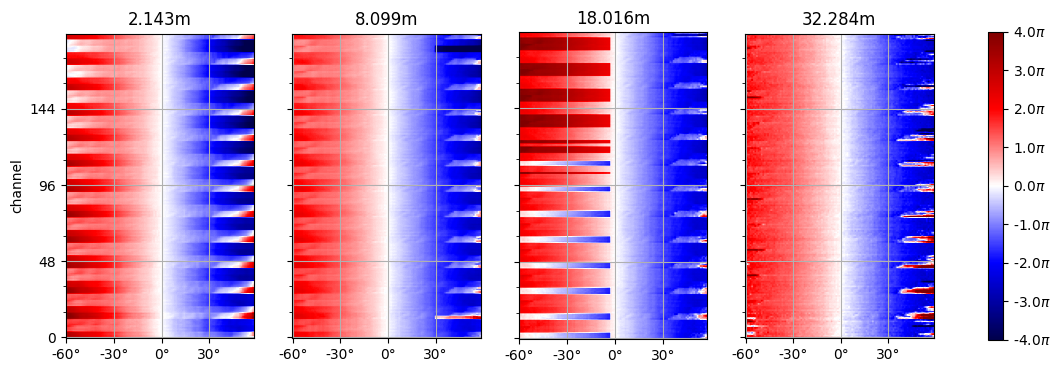

In [87]:
%matplotlib inline
fig, axes = plt.subplots(1,4, sharey=True)
for ax, dist, img, phase_est, angle in zip(axes.flat, dists, imgs, phase_ests, angles_filtered):
    img = numpy.unwrap(img, axis=-1)
    img -= img[:,60, None]
    phase_est_zerod = (phase_est - phase_est[:,60,None]).numpy()
    error = img-phase_est_zerod
    im = ax.imshow(error/pi, origin='lower', vmin=-4, vmax=4, cmap='seismic')
    ax.yaxis.set_ticks(range(0,192,16*3), minor=False)
    ax.yaxis.set_ticks(range(0,192,16), minor=True)
    ax.set_xticks(range(0, len(angle),30),\
                [f'{a}°' for a in range(int(round(angle[0]*180/pi-90,-1)),int(round(angle[-1]*180/pi-90,-1)),30)])
    ax.set_title(f'{dist}m')
    ax.grid()
axes[0].set_ylabel('channel')
fig.colorbar(im, ax=list(axes.flat), shrink=0.5, format=FuncFormatter(lambda x,pos: rf'{x:.1f}$\pi$'))
fig.set_size_inches(14,8)

Text(0.5, 0.98, '$k=8$,  $x_{Tx}=-2.14cm$, $x_{Rx}=3.79cm$')

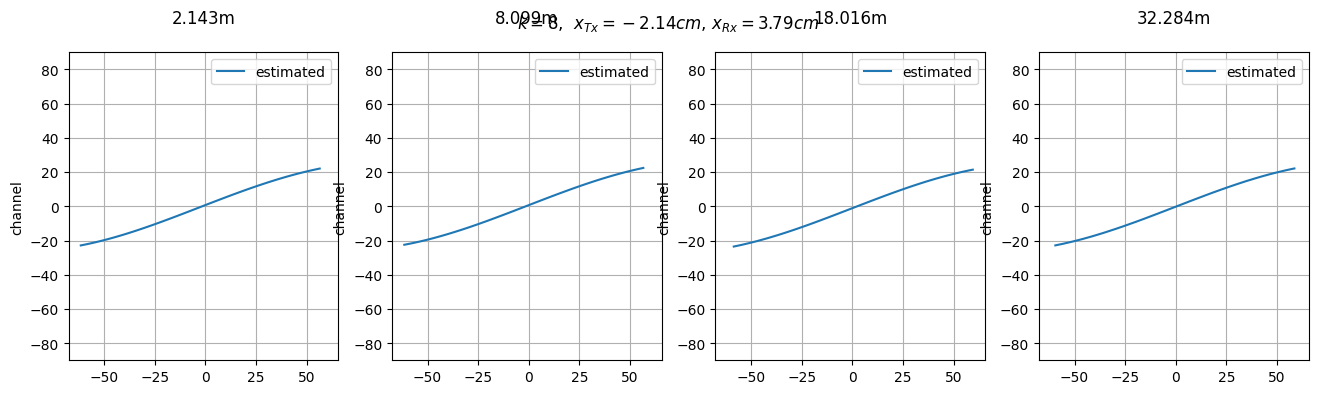

In [88]:
l=0
fig, axes = plt.subplots(1,4, sharex=True)
for ax, dist, img, phase_est, angle in zip(axes.flat, dists, imgs, phase_ests, angles_filtered):
    img = numpy.unwrap(img, axis=-1)
    img -= img[:,60, None]
    phase_est_zerod = (phase_est - phase_est[:,60,None]).numpy()
    ax.plot([180/pi*a-90 for a in angle], phase_est_zerod[k,:], label='estimated')
    ax.grid()
    ax.legend()
    ax.set_title(f'{dist}m\n')
    ax.set_ylim(-90,90)
    ax.set_ylabel('channel')
fig.set_size_inches(16,4)
fig.suptitle(r'$k={}$,  $x_{{Tx}}={:.2f}cm$, $x_{{Rx}}={:.2f}cm$'.format(k, tx[k]*100, rx[k]*100))


Text(0.5, 0.98, 'Phase estimation Error by virtual channel position')

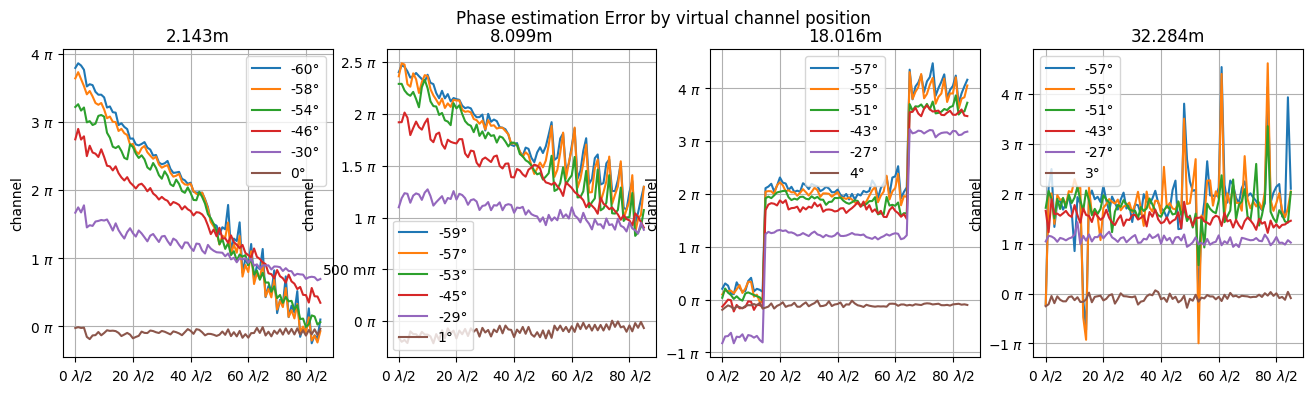

In [62]:
fig, axes = plt.subplots(1,4, sharex=True)
ula = [[x if y==0 else -1000 for x,y in zip(vx,vy)].index(x) for x in sorted(set(vx))]

for ax, dist, img, phase_est, angle in zip(axes.flat, dists, imgs, phase_ests, angles_filtered):
    img = numpy.unwrap(img, axis=-1)
    img -= img[:,60, None]
    for l in (2,4,8,16,32,62):
        ax.plot(sorted(set(vx)), (img[ula,l]-phase_est.numpy()[ula,l])/pi, label=f'{angle[l]*180/pi-90:.0f}°')
    phase_est -= phase_est[:,60,None]
    ax.yaxis.set_major_formatter(EngFormatter(r'$\pi$'))
    ax.xaxis.set_major_formatter(EngFormatter(r'$\lambda/2$'))
    ax.grid()
    ax.legend()
    ax.set_title(f'{dist}m')
    ax.set_ylabel('channel')
fig.set_size_inches(16,4)
fig.suptitle('Phase estimation Error by virtual channel position')

Text(0.5, 0.98, 'Phase estimation Error by virtual channel position')

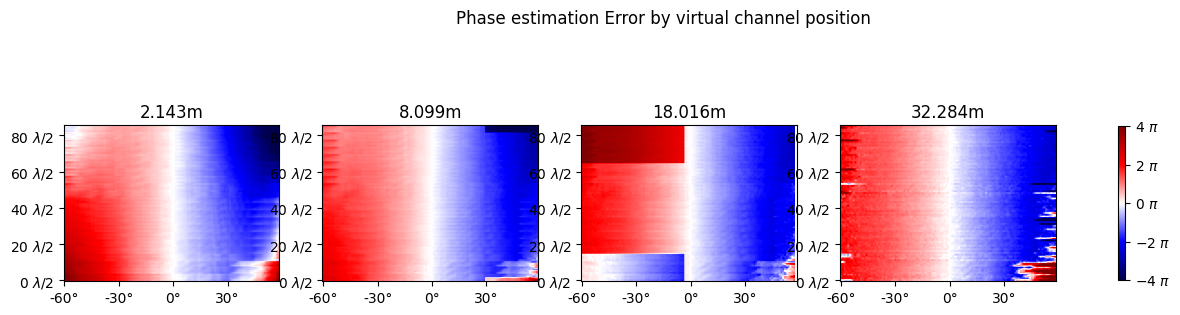

In [91]:
fig, axes = plt.subplots(1,4, sharex=True)
ula = [[x if y==0 else -1000 for x,y in zip(vx,vy)].index(x) for x in sorted(set(vx))]

for ax, dist, img, phase_est, angle in zip(axes.flat, dists, imgs, phase_ests, angles_filtered):
    img = numpy.unwrap(img, axis=-1)
    img -= img[:,60, None]
    phase_est_zerod = (phase_est - phase_est[:,60,None]).numpy()
    im = ax.imshow((img[ula,:]-phase_est_zerod[ula,:])/pi, origin='lower', cmap='seismic', vmin=-4, vmax=4)
    ax.set_xticks(range(0, len(angle),30),\
                [f'{a}°' for a in range(int(round(angle[0]*180/pi-90,-1)),int(round(angle[-1]*180/pi-90,-1)),30)])
    ax.set_title(f'{dist}m')
    ax.yaxis.set_major_formatter(EngFormatter(r'$\lambda/2$'))

fig.colorbar(im, ax=axes.ravel(), orientation='vertical', format=EngFormatter(r'$\pi$'), shrink=0.5)
fig.set_size_inches(16,4)
fig.suptitle('Phase estimation Error by virtual channel position')

In [266]:
angle = angles_filtered[0]
l_deg = l_degs[0]
fft = torch.load(f'{folder}a02_bp_fft.pt')[:,:,l_deg]
M,K,L = fft.shape

torch.Size([192, 119, 30])
torch.Size([192, 119, 30])
torch.Size([192, 119, 30])
torch.Size([192, 119, 30])
torch.Size([192, 119, 30])


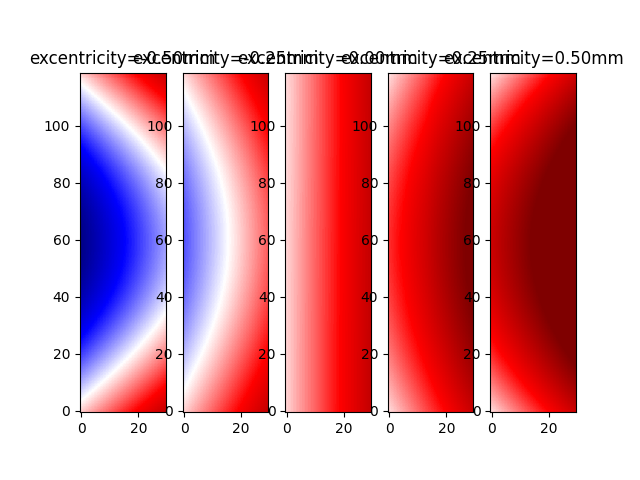

In [264]:
D = 30
fig, axes = plt.subplots(1,5)
for exc, ax in zip(torch.linspace(-0.5,.5,5), axes.flat):
    dists = torch.linspace(2.,2.2,D)
    # reflpos: [D] * [3,1,L,1] -> [3,1,L,D]
    reflpos = (dists-exc*1e-3)*torch.tensor([\
                list(map(lambda a: sin(a-pi/2),angle)),\
                [0]*L,\
                list(map(lambda a: cos(a-pi/2),angle))\
                ],\
            ).unsqueeze(1).unsqueeze(-1)
    assert (3,1,L,D) == tuple(reflpos.shape), f'{(3,1,L,D)} != {tuple(reflpos.shape)}'
    # txpos, rxpos: [3] -> [3,K,1,1]
    txpos = torch.tensor([tx, ty, [-exc]*K]).unsqueeze(-1).unsqueeze(-1)
    rxpos = torch.tensor([rx, ry, [-exc]*K]).unsqueeze(-1).unsqueeze(-1)
    assert (3,K,1,1) == tuple(txpos.shape), f'{(3,K,1,1)} != {txpos.shape}'

    # estimate: [3,K,L,D] -> [K,L,D]
    dist_est = (reflpos-txpos).square().sum(0).sqrt()/2 + (reflpos-rxpos).square().sum(0).sqrt()/2
    assert (K,L,D) == tuple(dist_est.shape), f'{(K,L,D)} != {dist_est.shape}'
    phase_est = -2*pi*f_start * (2*dist_est/lightspeed)
    phase_est -= phase_est.clone()[0,0,0]
    m_refl = ((dist_est-1.5)*bins_per_meter).clamp(0,bins_per_meter-1).long()
    assert (K,L,D) == tuple(m_refl.shape), f'{(K,L,D)} != {m_refl.shape}'
    assert (M,K,L) == tuple(fft.shape), f'{(M,K,L)} != {fft.shape}'
    phase_meas = torch.empty((K*L,D))
    for d in range(D):
        print(d, end=' \r')
        idx = m_refl.flatten(0,1)[:,d]
        phase_meas[:,d] = fft.angle().flatten(1,2)[idx,range(K*L)]
    phase_meas = phase_meas.unflatten(0, (K,L))
    phase_meas -= phase_meas.clone()[0,0,0]
    print(phase_meas.shape)
    ax.set_title(f'excentricity={exc:.2f}mm') 
    ax.imshow((numpy.unwrap(phase_meas,axis=1)-phase_est.numpy()).mean(0), origin='lower', cmap='seismic', vmin=-1000, vmax=1000)

#fig.set_size_inches(4,10)

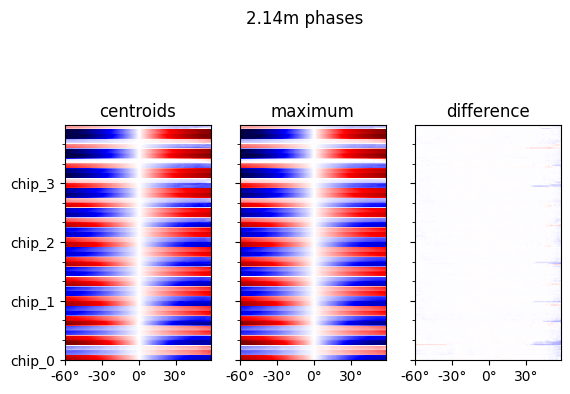

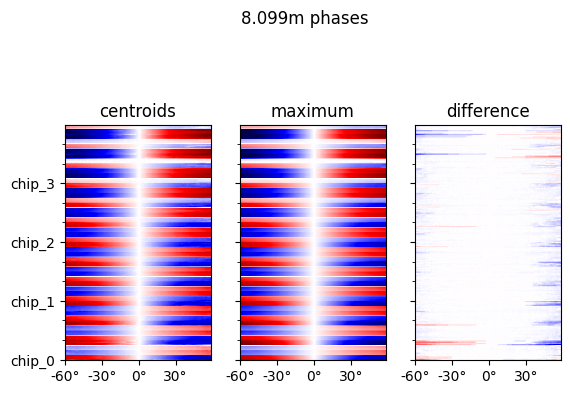

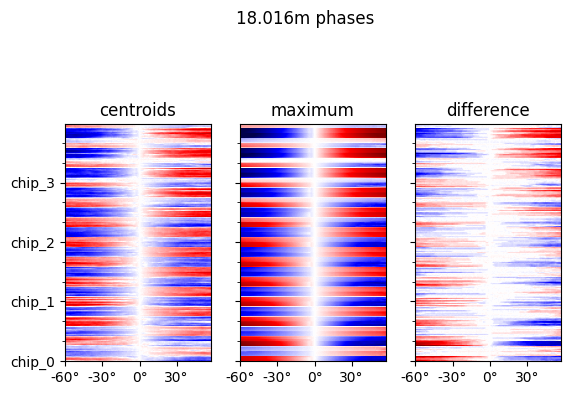

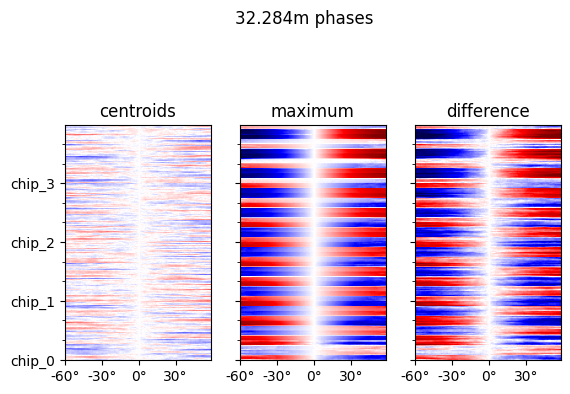

In [3]:
torch.Tensor.centroid = lambda self, dim : \
    (torch.arange(self.shape[dim], device=self.device) * self.movedim(dim,-1)).sum(-1)\
    / self.movedim(dim,-1).sum(-1) 


for n, dist in enumerate([2.140, 8.099, 18.016, 32.284]):
    angle = angles_filtered[n]
    l_deg = l_degs[n]
    fft = None
    fft = torch.load(f'{folder}a{int(dist):02d}_bp_fft.pt')[:,:,l_deg]
    M,K,L = fft.shape
    fig, (left,mid,right) = plt.subplots(1,3, sharey=True)

    m_refl = fft.abs().centroid(0).flatten().long()
    phase_centr = numpy.unwrap((fft.angle().flatten(1)[m_refl, range(K*L)]).unflatten(0, (K,L)), axis=-1)
    phase_centr -= phase_centr[:,60,None]
    left.imshow(phase_centr, origin='lower', cmap='seismic', vmin=-100, vmax=100)

    m_refl = fft.abs().argmax(0).flatten().long()
    phase_max = numpy.unwrap((fft.angle().flatten(1)[m_refl, range(K*L)]).unflatten(0, (K,L)), axis=-1)
    phase_max -= phase_max[:,60,None]
    mid.imshow(phase_max, origin='lower', cmap='seismic', vmin=-100, vmax=100)

    right.imshow(phase_max-phase_centr, origin='lower', cmap='seismic', vmin=-100, vmax=100)
    for ax in (left,right,mid):
        ax.set_xticks(range(0,L,30), [f'{a}°' for a in range(-60,60,30)])
    left.set_yticks(range(0,192,3*16),[f'chip_{n}' for n in range(4)], minor=False)
    left.set_yticks([k for k in range(0,192,16)], minor=True)

    left.set_title('centroids')
    mid.set_title('maximum')
    right.set_title('difference')
    fig.suptitle(f'{dist}m phases')

In [5]:
phase_maxs = []
for n, dist in enumerate([2.140, 8.099, 18.016, 32.284]):
    angle = angles_filtered[n]
    l_deg = l_degs[n]
    fft = None
    fft = torch.load(f'{folder}a{int(dist):02d}_bp_fft.pt')[:,185,l_deg]
    M,L = fft.shape
    K = 1

    m_refl = fft.abs().argmax(0).flatten().long()
    phase_max = numpy.unwrap((fft.angle().flatten(1)[m_refl, range(K*L)]).unflatten(0, (K,L)), axis=-1)
    phase_max -= phase_max[:,60,None]
    phase_maxs.append(phase_max)


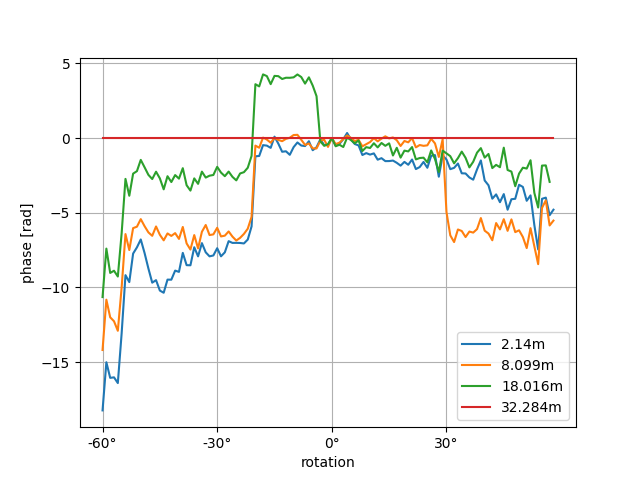

In [51]:
phasedif = lambda a, b : (torch.polar(torch.ones_like(a), a) / torch.polar(torch.ones_like(b), b)).angle()
plt.figure()
for dist, phase in zip([2.140, 8.099, 18.016, 32.284], phase_maxs):
    phase = phase.squeeze()
    ref = phase_maxs[-1].squeeze()[:phase.shape[0]]
    plt.plot(phase-ref, label=f'{dist}m')
plt.grid()
plt.ylabel('phase [rad]')
plt.xlabel('rotation')
plt.xticks(range(0,L,30), [f'{a}°' for a in range(-60,60,30)])
plt.legend()

In [46]:
angle = angles_filtered[0]
l_deg = l_degs[0]

fft = torch.load(f'{folder}a02_bp_fft.pt')[:,:,l_deg]
M,K,L = fft.shape


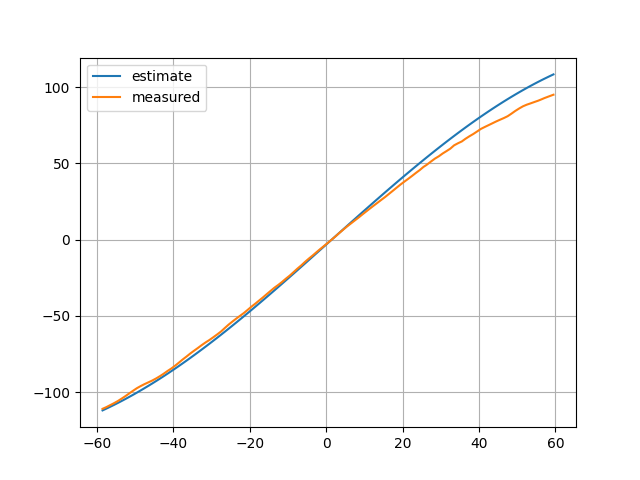

In [49]:
m_refl = fft.abs().argmax(0).flatten().long()

from math import sin,cos
reflpos = 2.14 * torch.tensor([\
                list(map(lambda a: sin(a-pi/2),angle)),\
                [0]*L,\
                list(map(lambda a: cos(a-pi/2),angle))\
                ])
txpos = torch.tensor([tx[k], ty[k], 0]).unsqueeze(-1)
rxpos = torch.tensor([rx[k], ry[k], 0]).unsqueeze(-1)
dist_est = (reflpos-txpos).square().sum(0).sqrt()/2 + (reflpos-rxpos).square().sum(0).sqrt()/2
phase_est = -2*pi*f_start * (2*dist_est/lightspeed)
phase_est -= phase_est.clone()[60]
phase_max = numpy.unwrap((fft.angle().flatten(1)[m_refl, range(K*L)]).unflatten(0, (K,L)), axis=-1).squeeze()
phase_max -= phase_max[60]

plt.figure()
plt.plot([a*180/pi-90 for a in angle], phase_est, label='estimate')
plt.plot([a*180/pi-90 for a in angle], phase_max, label='measured')
plt.grid()
plt.legend()


In [3]:
img1, img2, img3 = [], [], []
phasedif = lambda a, b : (torch.polar(torch.ones_like(a), a) / torch.polar(torch.ones_like(b), b)).angle()
dists = [2.140, 8.099, 18.016, 32.284]
from math import sin,cos
for dist, angle, l_deg in zip(dists, angles_filtered, l_degs):
    fft = torch.load(f'{folder}a{int(dist):02d}_bp_fft.pt')[:,:,l_deg]
    M,K,L = fft.shape
    reflpos = (dist)*torch.tensor([\
                list(map(lambda a: -sin(a-pi/2),angle)),\
                [0]*L,\
                list(map(lambda a: cos(a-pi/2),angle))\
                ]\
            ).unsqueeze(1)
    # txpos, rxpos: [3,K] -> [3,K,1]
    txpos = torch.tensor([tx, ty, [0]*K]).unsqueeze(-1)
    rxpos = torch.tensor([rx, ry, [0]*K]).unsqueeze(-1)
    #estimate: [3,K,L] -> [K,L]
    dist_est = (reflpos-txpos).square().sum(0).sqrt()/2 + (reflpos-rxpos).square().sum(0).sqrt()/2
    tau1 = (2*dist_est/lightspeed)
    phase_est = 2*pi*f_start * tau1 + pi*ramp_slope * tau1**2
    m_refl = fft.abs().argmax(0).flatten()

    phase_meas = fft.angle().flatten(1)[m_refl,range(K*L)].unflatten(0,(K,L))
    img1.append(phasedif(phase_est,phase_meas))
    tau2 = 2*(m_refl.unflatten(0,(K,L))/bins_per_meter+int(dist)-0.5)/lightspeed
    phase_est = 2*pi*f_start * tau2 + pi*ramp_slope * tau2**2
    img2.append(phasedif(phase_est,phase_meas))
    img3.append(lightspeed*(tau1-tau2))


Text(0.5, 0.98, 'Distance Estimation Error ')

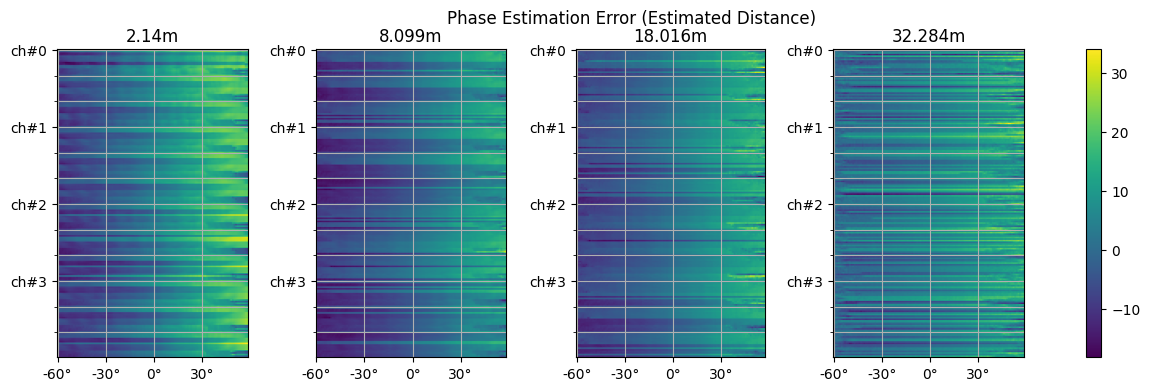

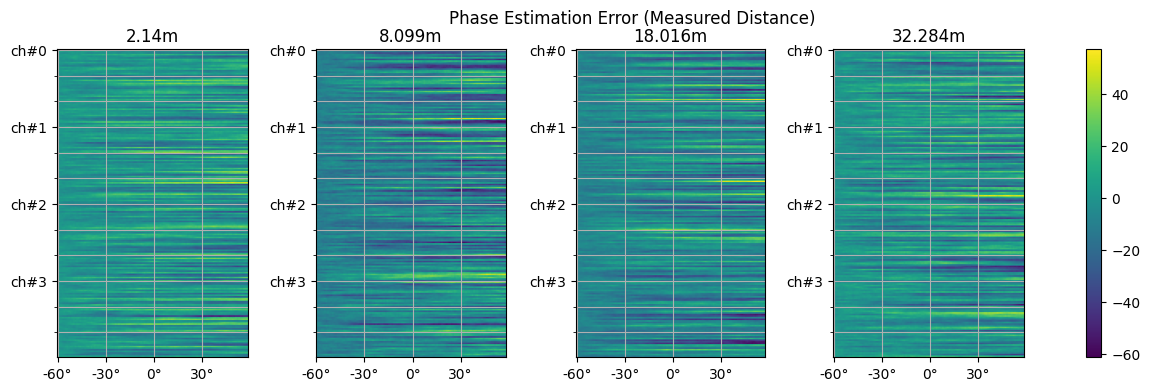

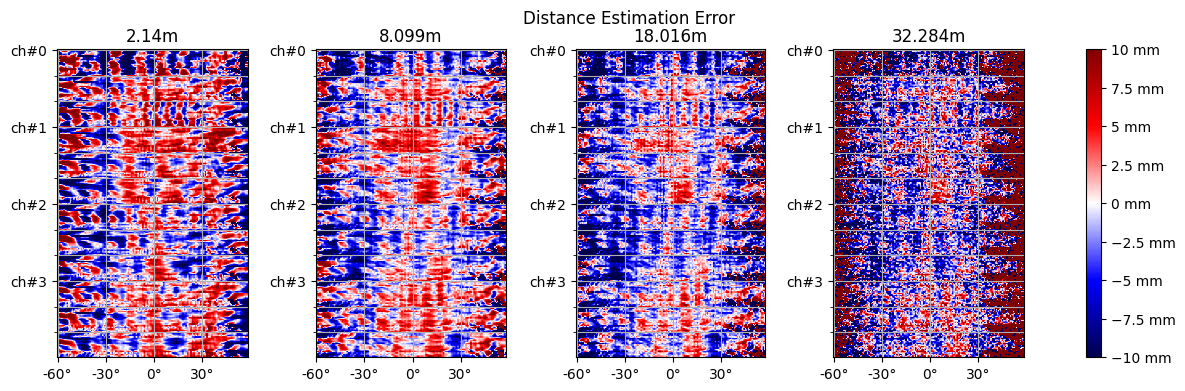

In [4]:
%matplotlib inline
fig, axes = plt.subplots(1,4)

for dist, ax, im1 in zip(dists, axes.flat, img1):
    im = ax.imshow(numpy.unwrap(im1))
    ax.set_title(f'{dist}m')
    ax.yaxis.set_ticks(range(0,192,16*3), [f'ch#{a}' for a in range(4)], minor=False)
    ax.yaxis.set_ticks(range(0,192,16), minor=True)
    ax.xaxis.set_ticks(range(0,120,30), [f'{a}°' for a in range(-60,60,30)])
    ax.grid(which='both')

fig.colorbar(im, ax=list(axes.flat))
fig.set_size_inches(16,4)
fig.suptitle('Phase Estimation Error (Estimated Distance)')

fig, axes = plt.subplots(1,4)

for dist, ax, im2 in zip(dists, axes.flat, img2):
    im = ax.imshow(numpy.unwrap(im2))
    ax.set_title(f'{dist}m')
    ax.yaxis.set_ticks(range(0,192,16*3), [f'ch#{a}' for a in range(4)], minor=False)
    ax.yaxis.set_ticks(range(0,192,16), minor=True)
    ax.xaxis.set_ticks(range(0,120,30), [f'{a}°' for a in range(-60,60,30)])
    ax.grid(which='both')

fig.colorbar(im, ax=list(axes.flat))
fig.set_size_inches(16,4)
fig.suptitle('Phase Estimation Error (Measured Distance)')

fig, axes = plt.subplots(1,4)
for dist, ax, img in zip(dists,axes.flat, img3):
    im = ax.imshow(1000*img/2, vmin=-10, vmax=10, cmap='seismic')
    ax.yaxis.set_ticks(range(0,192,16*3), [f'ch#{a}' for a in range(4)], minor=False)
    ax.yaxis.set_ticks(range(0,192,16), minor=True)
    ax.xaxis.set_ticks(range(0,120,30), [f'{a}°' for a in range(-60,60,30)])
    ax.grid(which='both')
    ax.set_title(f'{dist}m')
cbar = fig.colorbar(im, ax=list(axes.flat), format=EngFormatter('mm'))
fig.set_size_inches(16,4)
fig.suptitle('Distance Estimation Error ')


In [4]:
fft = torch.load(f'{folder}a02_bp_fft_wholedeg.pt')
M,K,L = fft.shape
angle_deg = pickle.load(open(folder + 'a02_angle_deg.pt', 'rb'))
l_zero = angle_deg.index(0)
print(angle_deg[l_zero])

0.0


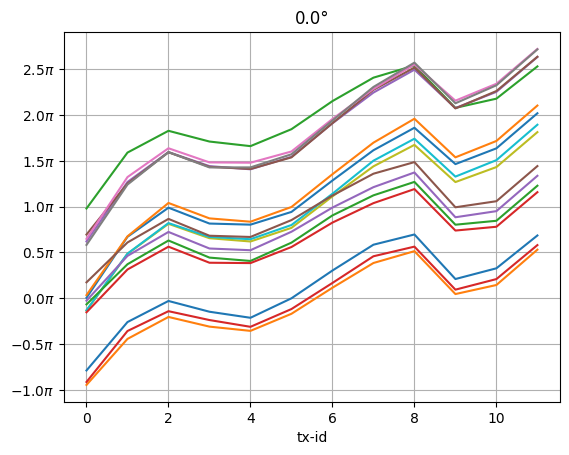

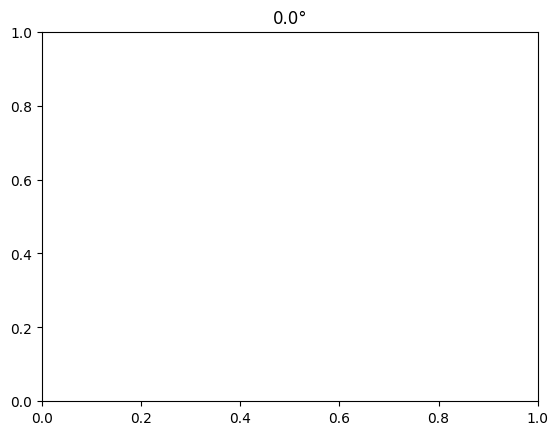

In [8]:
N_tx, N_rx = 12,16
l = l_zero
for nrx in range(N_rx):
    k = [16*ntx+nrx for ntx in range(N_tx)]
    m = fft[:,k,l].abs().argmax(0)
    plt.plot(1/pi*numpy.unwrap(fft[m,k,l].angle()), label=f'Rx{nrx:02d}')
plt.xlabel('tx-id')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x,pos: r'${:.1f}\pi$'.format(x)))
plt.title(f'{angle_deg[l]:.1f}°')
plt.grid()
plt.show()
plt.title(f'{angle_deg[l]:.1f}°')
#plt.ylim(-3,3)
#plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x,pos: r'${:.1f}\pi$'.format(x)))
plt.show()


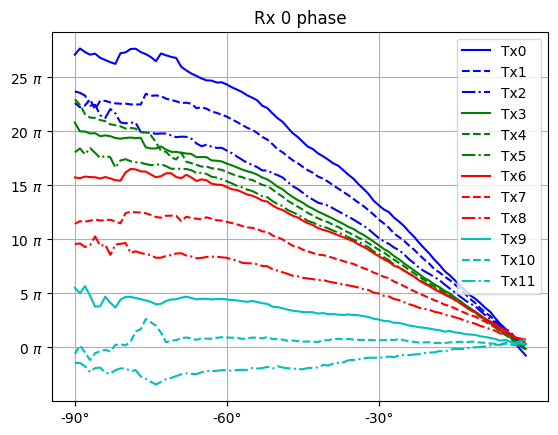

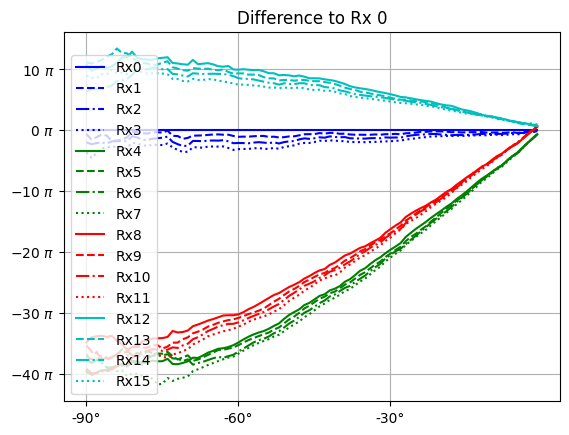

In [120]:
N_tx, N_rx = 12,16
phasedif = lambda a,b: (torch.exp(1j*a)/torch.exp(1j*b)).angle()

m_refl = fft.abs().flatten(1).argmax(0)
phase = fft.angle().flatten(1)[m_refl,range(K*L)].unflatten(0,(N_tx,N_rx,L)).flip(-1)

styles = [f'{col}{stl}' for col in 'bgrc' for stl in ['-','--','-.']]

for ntx, style in enumerate(styles):
    plt.plot(numpy.flip(numpy.unwrap(phase[ntx,0,l_zero::10]),-1)/pi, style, label=f'Tx{ntx}')
#plt.colorbar(orientation='horizontal', format=EngFormatter('$\\pi$'))
plt.title(f'Rx 0 phase')
plt.legend()
plt.gca().yaxis.set_major_formatter(EngFormatter(r'$\pi$'))
#plt.yticks(range(0,N_tx,3))
#plt.ylabel('tx_id')
plt.xticks([(angle_deg.index(a))//10 for a in range(-90,0,30)], [f'{a}°' for a in range(-90,0,30)])
plt.grid()
plt.show()

styles = [f'{col}{stl}' for col in 'bgrc' for stl in ['-','--','-.', ':']]

for nrx, style in enumerate(styles):
    plt.plot(numpy.flip(numpy.unwrap(phasedif(phase[0,nrx,l_zero::10],phase[0,0,l_zero::10]),-1))/pi, style, label=f'Rx{nrx}')
#plt.colorbar(orientation='horizontal', format=EngFormatter('$\\pi$'))
plt.title(f'Difference to Rx 0')
plt.legend()
plt.gca().yaxis.set_major_formatter(EngFormatter(r'$\pi$'))
#plt.yticks(range(0,N_tx,3))
#plt.ylabel('tx_id')
plt.xticks([(angle_deg.index(a))//10 for a in range(-90,0,30)], [f'{a}°' for a in range(-90,0,30)])
plt.grid()
plt.show()
